# 손실함수 (loss function)

## 이진분류 손실함수 Binary Cross Entropy

$$
\text{Loss} = -\left[y \cdot \log(p) + (1 - y) \cdot \log(1 - p)\right]
$$
- $y$: 실제 값 (0 또는 1)
- $p$: 예측 확률 (0과 1 사이)


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 정답이 1: - log(p)
print('정답이 1, 손실크면: ', -np.log(0.2))
print('정답이 1, 손실작으면: ', -np.log(0.8))

# 정답이 0: - log(1 - p)
print('정답이 0, 손실작으면: ', -np.log(1 - 0.2))
print('정답이 0, 손실크면: ', -np.log(1 - 0.8))

정답이 1, 손실크면:  1.6094379124341003
정답이 1, 손실작으면:  0.2231435513142097
정답이 0, 손실작으면:  0.2231435513142097
정답이 0, 손실크면:  1.6094379124341005


In [68]:
# 직접 구현
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-8 # 0.00000001 로그에 0이 들어올수도 있으니 작은 값 넣음
    return - (y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

y_true = np.array([1, 0, 1, 1])
y_pred = np.array([0.9, 0.1, 0.8, 0.7])

loss = binary_cross_entropy(y_true, y_pred)
loss

array([0.1053605 , 0.1053605 , 0.22314354, 0.35667493])

In [69]:
y_true = torch.tensor([1, 0, 1, 1], dtype=torch.float32)
y_pred = torch.tensor([0.9, 0.1, 0.8, 0.7])

criterion = nn.BCELoss()
loss = criterion(y_pred, y_true)
loss

tensor(0.1976)

In [70]:
# torch 손실함수 BCEWithLogitsLoss
# - 입력: logits
# - BCELoss 확률값이 0, 1에 가까우면, 수치계산 불안정, 이를 보완한 손실함수
logits = torch.tensor([2.173, -2.345, 1.386, -0.405], dtype=torch.float32) # 출력층 선형방정식 결과값
y_true = torch.tensor([1, 0, 1, 1], dtype=torch.float32)

# sigmoid + BCELoss
p = torch.sigmoid(logits)
criterion = nn.BCELoss()
loss = criterion(p, y_true)
print(loss)

# BCEWithLogitLoss
criterion2 = nn.BCEWithLogitsLoss()
loss = criterion2(logits, y_true)
print(loss)


tensor(0.3346)
tensor(0.3346)


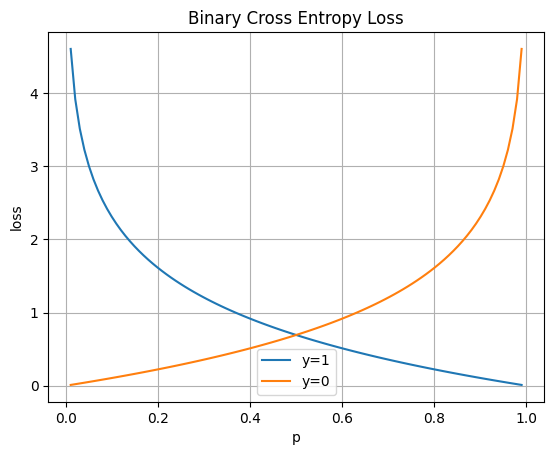

In [71]:
# 손실함수 시각화
p = np.linspace(0.01, 0.99, 100) # 시그모이드 통과한 확률값

loss_1 = -np.log(p)
loss_0 = -np.log(1 - p)

plt.plot(p, loss_1, label='y=1')
plt.plot(p, loss_0, label='y=0')

plt.title('Binary Cross Entropy Loss')
plt.xlabel('p')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

## 다중분류 손실함수 Cross Entropy
모델이 출력한 점수(logits)를 softmax 함수로 확률로 바꾼 뒤, 정답 클래스의 log 확률을 취한 값을 손실로 계산한다.

$$
\text{Loss} = -\log(\text{softmax}(\text{logits})[y])
$$

**수식 전체**

$$
\text{Loss} = -\log\left( \frac{e^{z_y}}{\sum_{j} e^{z_j}} \right)
$$

* $z = [z_0, z_1, ..., z_k]$: 각 클래스에 대한 모델의 출력값 (logits)
* $z_y$: 정답 클래스 $y$에 해당하는 로짓 값
* $\sum_j e^{z_j}$: 모든 클래스에 대한 softmax 분모

In [72]:
# 직접 구현
y_true = 0
z = torch.tensor([2.0, 1.0, 0.1])
p = F.softmax(z, dim=0)
print(p)

pred = p.argmax(dim=0)
-np.log(p.numpy()[y_true])

tensor([0.6590, 0.2424, 0.0986])


np.float32(0.41702995)

In [73]:
# torch의 crossEntropyLoss
y_true = torch.tensor([0], dtype=torch.long) # long만 허용
z = torch.tensor([[2.0, 1.0, 0.10]]) # 배치 사이즈 때문에 [] 하나 더 감쌈

criterion = nn.CrossEntropyLoss()
loss = criterion(z, y_true) # pred값을 먼저 넣어야 함
print(loss.item())

0.4170299470424652


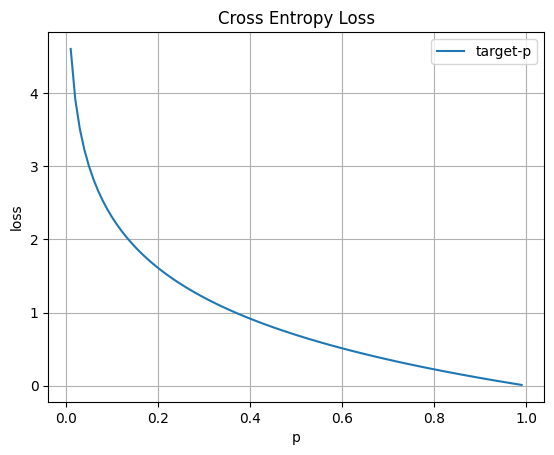

In [74]:
# 시각화
p = np.linspace(0.01, 0.99, 100)
loss = -np.log(p)
plt.plot(p, loss, label='target-p')
plt.title('Cross Entropy Loss')
plt.xlabel('p')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

## 회귀 손실함수

**1. MSELoss (Mean Squared Error Loss)**

**정의**: 오차(예측 - 실제)의 **제곱** 평균값을 계산

**특징**: 큰 오차에 더 큰 패널티 → 이상치에 민감

**수식**

$$
\text{MSELoss} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

**2. L1Loss 또는 MAELoss (Mean Absolute Error Loss)**

**정의**: 오차(예측 - 실제)의 **절댓값** 평균

**특징**: 이상치에 덜 민감하지만, 미분 불연속점 존재

**수식**

$$
\text{MAELoss} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

**3. HuberLoss (Smooth L1 Loss)**

**정의**: 작은 오차에는 MSE처럼, 큰 오차에는 MAE처럼 동작

**특징**: 이상치에 덜 민감하면서도 미분 가능 → **타협형 손실함수**

**수식** (임계값 $\delta$를 기준으로 나뉨)

$$
\text{HuberLoss}(y_i, \hat{y}_i) =
\begin{cases}
\frac{1}{2}(y_i - \hat{y}_i)^2 & \text{if } |y_i - \hat{y}_i| \leq \delta \\
\delta \cdot \left( |y_i - \hat{y}_i| - \frac{1}{2}\delta \right) & \text{otherwise}
\end{cases}
$$

[ 0.5 -0.5 -0.1 -0.8 35.5 52.3]


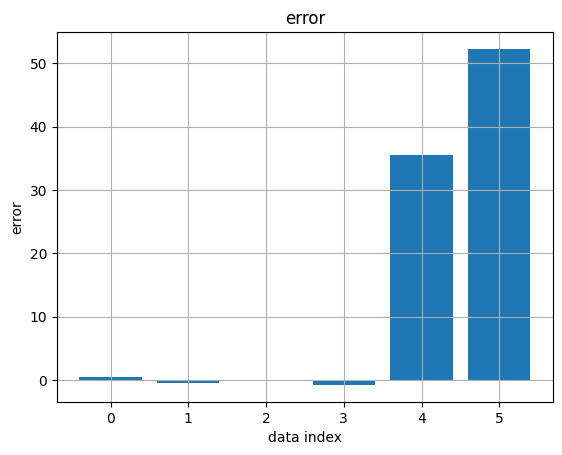

In [75]:
# 이상치가 없는 경우
# y_true = np.array([3.0, -0.5, 2.0, 7.0])
# y_pred - np.array([2.5, 0.0, 2.1, 7.8])


y_true = np.array([3.0, -0.5, 2.0, 7.0, 50.5, 60.0])
y_pred = np.array([2.5, 0.0, 2.1, 7.8, 15.0, 7.7])

error = y_true - y_pred
print(error)

plt.bar(range(len(y_true)), error)
plt.title('error')
plt.xlabel('data index')
plt.ylabel('error')
plt.grid()
plt.show()

In [76]:
# 손실함수별 비교
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def huber_loss(y_true, y_pred, delta=1.0):
    """
    delta보다 작은 오차엔 MSE
    delta보다 큰 오차엔 MAE
    """
    error = y_true - y_pred
    is_small_error = error <= delta
    return np.mean(np.where(is_small_error, 0.5 * (error ** 2), delta * (np.abs(error) - 0.5 * delta)))

y_true = np.array([3.0, -0.5, 2.0, 7.0, 50.5, 60.0])
y_pred = np.array([2.5, 0.0, 2.1, 7.8, 15.0, 7.7])

print('mse: ', mse(y_true, y_pred))
print('mae: ', mae(y_true, y_pred))
print('huber_loss: ', huber_loss(y_true, y_pred))

mse:  666.1149999999999
mae:  14.949999999999998
huber_loss:  14.5625


In [77]:
# torch 버전
y_true = torch.tensor([3.0, -0.5, 2.0, 7.0, 50.5, 60.0], dtype=torch.float32)
y_pred = torch.tensor([2.5, 0.0, 2.1, 7.8, 15.0, 7.7], dtype=torch.float32)

print('mse: ', F.mse_loss(y_true, y_pred))
print('mse (객체): ', nn.MSELoss()(y_true, y_pred)) # 객체로도 가능
print('mae (L1 loss): ', F.l1_loss(y_true, y_pred))
print('huber_loss: ', F.huber_loss(y_true, y_pred))
print('smooth_l1_loss: ', F.smooth_l1_loss(y_true, y_pred))



mse:  tensor(666.1150)
mse (객체):  tensor(666.1150)
mae (L1 loss):  tensor(14.9500)
huber_loss:  tensor(14.5625)
smooth_l1_loss:  tensor(14.5625)


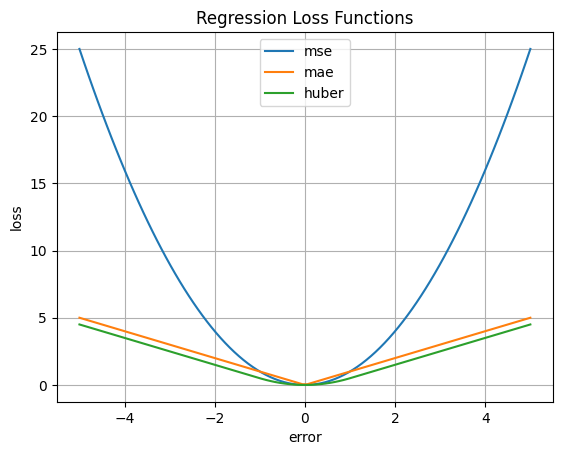

In [78]:
# 시각화
errors = torch.linspace(-5, 5, 100)

# 손실함수 객체
# reduction=mean 여러 오차를 평균내어 스칼라 반환
# reduction=none 여러 오차를 그대로 반환
mse_fn = nn.MSELoss(reduction='none') 
mae_fn = nn.L1Loss(reduction='none')  
huber_fn = nn.HuberLoss(reduction='none')


# 정답/예측
y_true = torch.zeros_like(errors)
y_pred = errors

# 손실계산
mse_loss = mse_fn(y_pred, y_true).numpy()
mae_loss = mae_fn(y_pred, y_true).numpy()
huber_loss = huber_fn(y_pred, y_true).numpy()
errors = errors.numpy()

# 시각화
plt.plot(errors, mse_loss, label='mse')
plt.plot(errors, mae_loss, label='mae')
plt.plot(errors, huber_loss, label='huber')

plt.title('Regression Loss Functions')
plt.legend()
plt.xlabel('error')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

### 신경망 모델에서 손실 함수 사용

In [79]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 생성
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42
)

# 전처리
scaler = StandardScaler()
X - scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


def one_hot(labels, num_classes):
    return np.eye(num_classes)[labels]

y_train_oh = one_hot(y_train, 2)
y_test_oh = one_hot(y_test, 2)

In [80]:
X_train.shape

(750, 20)

In [81]:
# 모델 파라미터 초기화
np.random.seed(42)

input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 2

W1 = np.random.randn(input_dim, hidden_dim)
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim)
b2 = np.zeros((1, output_dim))
print(W1.shape, b1.shape, W2.shape, b2.shape)

(20, 32) (1, 32) (32, 2) (1, 2)


In [82]:
# 활성화 함수, 손실 함수 정의

# 은닉층에서 씀
def relu(z):
    return np.maximum(0, z)

# 출력층에서 씀
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(probs, labels):
    m = labels.shape[0]
    log_likelihood = -np.log(probs + 1e-8) * labels
    loss = np.sum(log_likelihood) / m
    return loss

In [83]:
# 학습
learning_rate = 0.01
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    # forward
    Z1 = np.dot(X_train, W1) + b1               # 은닉층거침
    R1 = relu(Z1)                               # 은닉층의 활성함수
    Z2 = np.dot(R1, W2) + b2                    # 출력층거침
    probs = softmax(Z2)                         # 출력층의 활성함수
    loss = cross_entropy_loss(probs, y_train_oh)# 손실함수 계산

    # backpropagation
    m = X_train.shape[0]
    dZ2 = (probs - y_train_oh) / m
    dW2 = np.dot(R1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    
    dR1 = np.dot(dZ2, W2.T)
    dZ1 = dR1 * (Z1 > 0)
    dW1 = np.dot(X_train.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    # 파라미터 업데이트
    W1 -= learning_rate * dW1   # 학습률에 기울기 곱하고 뺌
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    train_losses.append(loss)

    # 테스트 데이터로 손실 확인
    Z1_test = np.dot(X_test, W1) + b1
    R1_test = relu(Z1_test)
    Z2_test = np.dot(R1_test, W2) + b2
    probs_test = softmax(Z2_test)
    loss_test = cross_entropy_loss(probs_test, y_test_oh)

    test_losses.append(loss_test)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} | 학습 손실: {loss:.4f} 테스트 손실: {loss_test:.4f}")

Epoch 10 | 학습 손실: 5.6000 테스트 손실: 6.5055
Epoch 20 | 학습 손실: 4.5973 테스트 손실: 5.4199
Epoch 30 | 학습 손실: 3.9817 테스트 손실: 4.6023
Epoch 40 | 학습 손실: 3.4682 테스트 손실: 4.0325
Epoch 50 | 학습 손실: 3.0681 테스트 손실: 3.5790


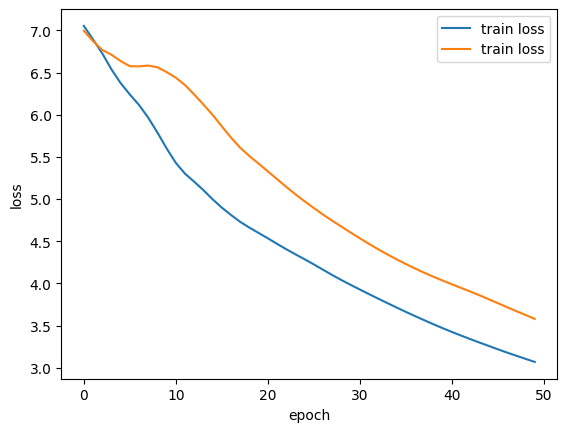

In [84]:
# 시각화
plt.plot(range(epochs), train_losses, label="train loss")
plt.plot(range(epochs), test_losses, label="train loss")


plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 기본 손실 함수 vs 커스텀 손실 함수

In [85]:
from sklearn.datasets import make_regression

# 데이터 생성
X, y = make_regression(
    n_samples=1000,
    n_features=10,
    noise=50,
    random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
# 예측 함수
def predict(X, w, b):
    return np.dot(X, w) + b

In [87]:
# 손실 함수
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

def my_loss(y_pred, y_true, w, lambda_reg=1.0):
    mse = mse_loss(y_pred, y_true)
    l2_reg = np.sum(w ** 2)
    return mse + (lambda_reg * l2_reg)

In [88]:
def train_model(X_train, y_train, X_test, y_test, loss_fn, epoch=100, learning_rate=0.1, use_custom=False):
    np.random.seed(42)
    n_features = X_train.shape[1]
    W = np.random.randn(n_features)
    b = 0.0

    for epoch in range(epochs):
        y_pred_train = predict(X_train, W, b)
        y_pred_test = predict(X_test, W, b)

        train_loss = loss_fn(y_pred_train, y_train, W) if use_custom else loss_fn(y_pred_train, y_train)
        test_loss = loss_fn(y_pred_test, y_test, W) if use_custom else loss_fn(y_pred_test, y_test)

        d_loss = 2 * (y_pred_train - y_train) / X_train.shape[0]
        grad_w = np.dot(X_train.T, d_loss)
        grad_b = np.sum(d_loss)

        if use_custom:
            grad_w += 2 * 1.0 * W

        W -= learning_rate * grad_w
        b -= learning_rate * grad_b

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1} | 학습 손실: {test_loss:.4f}, 테스트 손실: {test_loss:.4f} ')

In [89]:
train_model(X_train, y_train, X_test, y_test, mse_loss)


Epoch 10 | 학습 손실: 0.1833, 테스트 손실: 0.1833 
Epoch 20 | 학습 손실: 0.1255, 테스트 손실: 0.1255 
Epoch 30 | 학습 손실: 0.1242, 테스트 손실: 0.1242 
Epoch 40 | 학습 손실: 0.1241, 테스트 손실: 0.1241 
Epoch 50 | 학습 손실: 0.1241, 테스트 손실: 0.1241 


In [90]:
train_model(X_train, y_train, X_test, y_test, my_loss, use_custom=True)

Epoch 10 | 학습 손실: 0.5544, 테스트 손실: 0.5544 
Epoch 20 | 학습 손실: 0.5548, 테스트 손실: 0.5548 
Epoch 30 | 학습 손실: 0.5550, 테스트 손실: 0.5550 
Epoch 40 | 학습 손실: 0.5550, 테스트 손실: 0.5550 
Epoch 50 | 학습 손실: 0.5550, 테스트 손실: 0.5550 


In [91]:
### 손실 함수 선택이 모델 성능에 미치는 영향

In [92]:
# 데이터 생성
X, y = make_regression(
    n_samples=1000,
    n_features=5,
    noise=30,
    random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
# 선형 회귀 모델 예측 함수
def predict(X, w, b):
    return np.dot(X, w) + b

In [94]:
# 손실 함수
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

def mae_loss(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true))

def huber_loss(y_pred, y_true, delta=1.0):
    error = y_pred - y_true
    is_small_error = np.abs(error) <= delta
    squared_error = 0.5 * error**2
    linear_error = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_error, linear_error))

In [95]:
def train_regression(X, y, loss_fn, epochs=100, learning_rate= 0.01):
    n_features = X.shape[1]
    W = np.random.randn(n_features)
    b = 0.0
    m = X.shape[0]
    epsilon = 1e-5
    losses = []

    for epoch in range(epochs):
        y_pred = predict(X, W, b)
        loss = loss_fn(y_pred, y)
        losses.append(loss)

        grad_w = np.zeros_like(W)
        for i in range(len(W)):
            W_eps = np.copy(W)
            W_eps[i] += epsilon
            loss_eps = loss_fn(predict(X, W_eps, b), y)
            grad_w[i] += (loss_eps - loss) / epsilon

        b_eps = b + epsilon
        loss_eps_b = loss_fn(predict(X, W, b_eps), y)
        grad_b = (loss_eps_b - loss) / epsilon

        W -= learning_rate * grad_w
        b -= learning_rate * grad_b

    return W, b, losses

In [124]:
results = {}

for name, loss_fn in zip(['MSE', 'MAE', 'Huber'], [mse_loss, mae_loss, huber_loss]):
    W, b, losses = train_regression(X_train, y_train, loss_fn)
    results[name] = {'losses': losses}

    pred_test = predict(X_test, W, b)
    test_loss = mse_loss(pred_test, y_test)
    print(f'{name} Loss: {test_loss:.4f}')

MSE Loss: 0.3924
MAE Loss: 4.1927
Huber Loss: 4.4183


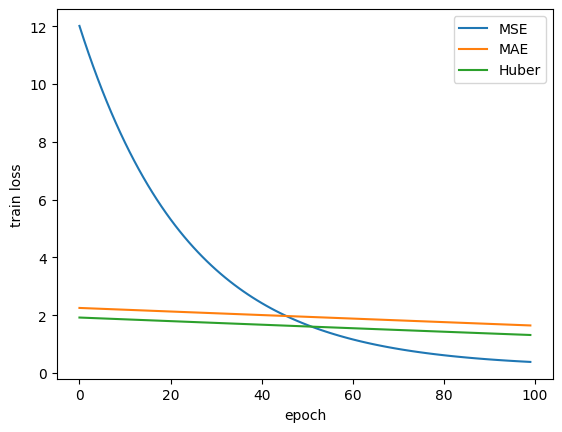

In [126]:
for name, value in results.items():
    plt.plot(value["losses"], label=name)

plt.xlabel('epoch')
plt.ylabel('train loss')
plt.legend()
plt.show()